# NB3 — Rule-based validation (minimal backtest)

A minimal, reproducible backtest to validate whether the **core signal** (regime_bucket_10 × zscore) can be traded with simple rules.

**Objectves**
1) Convert signal insights (NB1/NB2) into explicit trade rules.
2) Simulate trades per ticker using only forward-realizable information (no leakage).
3) Evaluate:
   - average return per trade
   - win rate
   - distribution (p5/p50/p95)
   - trade frequency (n trades)
   - stability across tickers and time splits

### 1. Imports + config

In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import bigquery


### 2. Load env + credentials

In [6]:
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

print("GCP_PROJECT_ID =", PROJECT_ID)
print("GOOGLE_APPLICATION_CREDENTIALS =", KEY_PATH)

BQ_DATASET = "mag7_intel_core"
BQ_TABLE   = "fact_regimes"
T_FACT_REGIMES = f"`{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`"

print("Targted Table =", TABLE)

# Analysis params
TICKERS = None         # None = all tickers, or set like ["AAPL","MSFT"]
START_DATE = None      # "2015-01-01"
END_DATE   = None      # "2025-12-31"
MAX_ROWS   = None      # e.g. 2_000_000 if you want a hard cap


GCP_PROJECT_ID = robotic-weft-480502-c2
GOOGLE_APPLICATION_CREDENTIALS = /home/shpang/.keys/robotic-weft-480502-c2.json
Targted Table = `robotic-weft-480502-c2.mag7_intel_core.fact_regimes`


### 3. BQ client

In [7]:
client = bigquery.Client(project=PROJECT_ID)

### 4. — SQL Query helper + data pull (from fact_regimes)

In [8]:
HOLD_DAYS = 20  # match forward return horizon
HORIZON_COL = f"fwd_return_{HOLD_DAYS}d"

sql = f"""
SELECT
  trade_date,
  ticker,
  regime_bucket_10,
  zscore_bucket_10,
  price_zscore_20d,
  {HORIZON_COL} AS fwd_ret
FROM {T_FACT_REGIMES}
WHERE regime_bucket_10 IS NOT NULL
  AND zscore_bucket_10 IS NOT NULL
  AND {HORIZON_COL} IS NOT NULL
ORDER BY ticker, trade_date
"""

df = client.query(sql).to_dataframe()
df["trade_date"] = pd.to_datetime(df["trade_date"])
df["regime_bucket_10"] = df["regime_bucket_10"].astype(int)
df["zscore_bucket_10"] = df["zscore_bucket_10"].astype(int)

df.head(), df.shape


/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  regime_bucket_10  zscore_bucket_10  price_zscore_20d  \
 0 2020-01-03   AAPL                 1                 3         -0.707107   
 1 2020-01-06   AAPL                 9                 5          0.390946   
 2 2020-01-07   AAPL                 4                 4         -0.453308   
 3 2020-01-08   AAPL                10                 8          1.524996   
 4 2020-01-09   AAPL                10                10          1.831300   
 
     fwd_ret  
 0  0.037757  
 1  0.063543  
 2  0.077281  
 3  0.072628  
 4  0.036041  ,
 (10311, 6))

### 5. Define baseline signal rules

These are starter rules consistent with the heatmap interpretation:
- Long only
- Trade only extremes (avoid noisy middle)

In [9]:
# --- Core entry rules (starter) ---
# Cheap + oversold
REGIME_MAX = 3              # cheap regimes
ZSCORE_MAX_BUCKET = 3       # oversold buckets

# Alternative: numeric threshold on zscore instead of bucket
USE_ZSCORE_NUMERIC = False
ZSCORE_THRESHOLD = -1.0     # oversold if price_zscore_20d <= -1

def compute_entry_signal(frame: pd.DataFrame) -> pd.Series:
    if USE_ZSCORE_NUMERIC:
        return (frame["regime_bucket_10"] <= REGIME_MAX) & (frame["price_zscore_20d"] <= ZSCORE_THRESHOLD)
    return (frame["regime_bucket_10"] <= REGIME_MAX) & (frame["zscore_bucket_10"] <= ZSCORE_MAX_BUCKET)

df["entry_signal"] = compute_entry_signal(df)
df[["trade_date","ticker","regime_bucket_10","zscore_bucket_10","price_zscore_20d","entry_signal"]].head(20)


,trade_date,ticker,regime_bucket_10,zscore_bucket_10,price_zscore_20d,entry_signal
0,2020-01-03,AAPL,1,3,-0.707107,True
1,2020-01-06,AAPL,9,5,0.390946,False
2,2020-01-07,AAPL,4,4,-0.453308,False
3,2020-01-08,AAPL,10,8,1.524996,False
4,2020-01-09,AAPL,10,10,1.831300,False
5,2020-01-10,AAPL,10,8,1.441340,False
6,2020-01-13,AAPL,10,9,1.776238,False
7,2020-01-14,AAPL,8,7,1.022903,False
8,2020-01-15,AAPL,8,6,0.766841,False
9,2020-01-16,AAPL,10,7,1.172372,False


### 6. Generate trades (avoid overlapping positions)

Simple model:
- When entry_signal is true, open a trade.
- Hold for HOLD_DAYS (use fwd_ret as realized return).
- Do not open a new trade if one is already open for that ticker.

In [10]:
def simulate_trades_no_overlap(frame: pd.DataFrame, hold_days: int) -> pd.DataFrame:
    """
    Per ticker:
      - Enter when entry_signal is True and not currently in a position.
      - Exit after hold_days (we use precomputed fwd_ret as trade return).
      - Skip signals during holding period (no overlap).
    """
    trades = []
    for ticker, g in frame.sort_values("trade_date").groupby("ticker"):
        in_pos_until = None
        for _, row in g.iterrows():
            d = row["trade_date"]
            if in_pos_until is not None and d <= in_pos_until:
                continue  # still holding
            if row["entry_signal"]:
                # Enter today, exit after hold_days (represented by fwd_ret)
                trades.append({
                    "ticker": ticker,
                    "entry_date": d,
                    "hold_days": hold_days,
                    "ret": float(row["fwd_ret"]),
                    "regime_bucket_10": int(row["regime_bucket_10"]),
                    "zscore_bucket_10": int(row["zscore_bucket_10"]),
                    "price_zscore_20d": float(row["price_zscore_20d"]) if row["price_zscore_20d"] is not None else np.nan
                })
                in_pos_until = d + pd.tseries.offsets.BDay(hold_days)  # approximate trading days
    return pd.DataFrame(trades)

trades = simulate_trades_no_overlap(df, HOLD_DAYS)
trades.head(), trades.shape


(  ticker entry_date  hold_days       ret  regime_bucket_10  zscore_bucket_10  \
 0   AAPL 2020-01-03         20  0.037757                 1                 3   
 1   AAPL 2020-02-24         20 -0.247535                 1                 1   
 2   AAPL 2020-03-24         20  0.118357                 3                 3   
 3   AAPL 2022-05-11         20 -0.026348                 2                 1   
 4   AAPL 2022-06-09         20  0.015634                 2                 3   
 
    price_zscore_20d  
 0         -0.707107  
 1         -2.703031  
 2         -0.865012  
 3         -2.333911  
 4         -0.537729  ,
 (108, 7))

### 7. Trade-level performance summary (per ticker + overall)

In [11]:
def perf_summary(tr: pd.DataFrame, label: str = "") -> pd.DataFrame:
    if tr.empty:
        return pd.DataFrame([{"label": label, "n": 0}])

    out = {
        "label": label,
        "n": len(tr),
        "avg_ret": tr["ret"].mean(),
        "med_ret": tr["ret"].median(),
        "win_rate": (tr["ret"] > 0).mean(),
        "p05": tr["ret"].quantile(0.05),
        "p25": tr["ret"].quantile(0.25),
        "p75": tr["ret"].quantile(0.75),
        "p95": tr["ret"].quantile(0.95),
    }
    return pd.DataFrame([out])

overall = perf_summary(trades, label="overall")
by_ticker = (trades.groupby("ticker", as_index=False)
                  .apply(lambda x: perf_summary(x, label=x["ticker"].iloc[0]))
                  .reset_index(drop=True))

overall, by_ticker.sort_values("avg_ret", ascending=False)


/tmp/ipykernel_2622652/313489364.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: perf_summary(x, label=x["ticker"].iloc[0]))


(     label    n   avg_ret   med_ret  win_rate       p05       p25       p75  \
 0  overall  108  0.017198  0.017164  0.546296 -0.212036 -0.089534  0.098899   
 
         p95  
 0  0.255516  ,
    label   n   avg_ret   med_ret  win_rate       p05       p25       p75  \
 6   TSLA  16  0.039975  0.041668  0.625000 -0.200451 -0.090712  0.099041   
 4   MSFT  15  0.027933  0.005714  0.600000 -0.083535 -0.045341  0.086333   
 5   NVDA  14  0.025613  0.029479  0.642857 -0.234841 -0.105404  0.103648   
 2  GOOGL  18  0.022086  0.025094  0.555556 -0.127946 -0.071563  0.101812   
 1   AMZN  16  0.018604  0.016930  0.500000 -0.140733 -0.055926  0.089071   
 0   AAPL  14  0.001483  0.015958  0.642857 -0.168007 -0.033400  0.058328   
 3   META  15 -0.018384 -0.089623  0.266667 -0.198473 -0.109400  0.050765   
 
         p95  
 6  0.369264  
 4  0.167600  
 5  0.277557  
 2  0.180611  
 1  0.177766  
 0  0.144683  
 3  0.318072  )

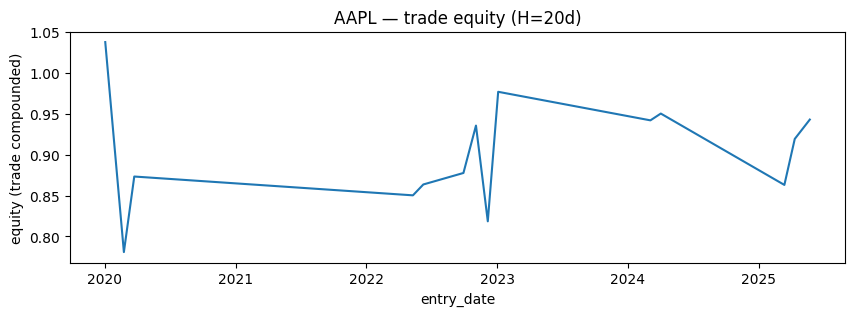

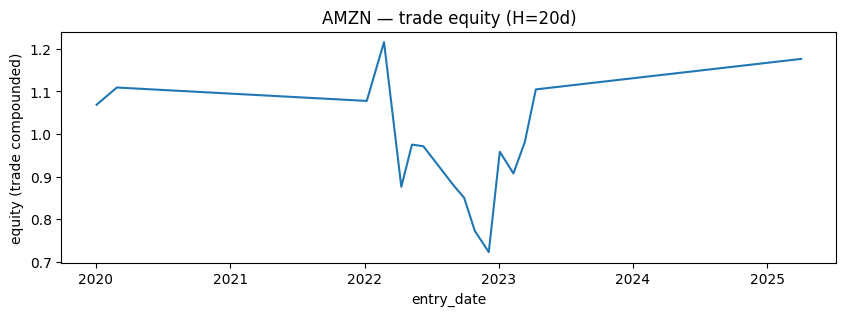

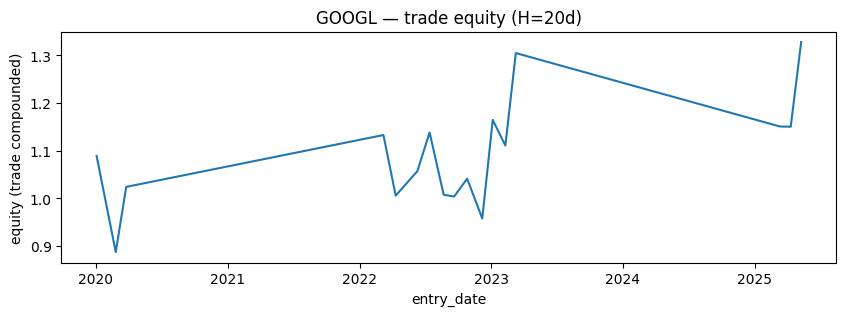

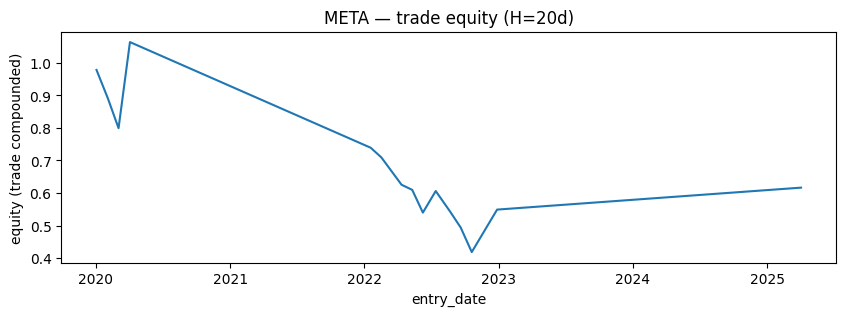

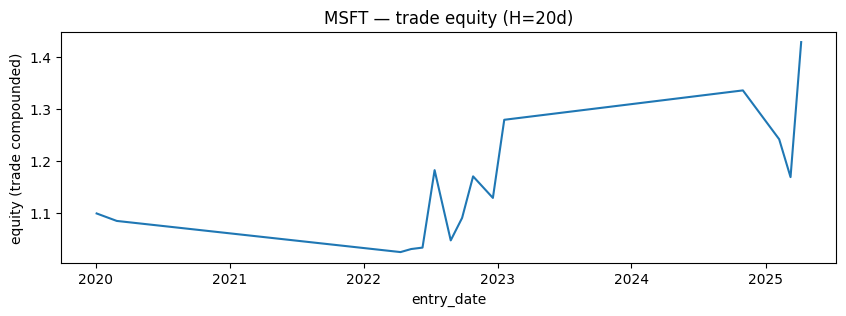

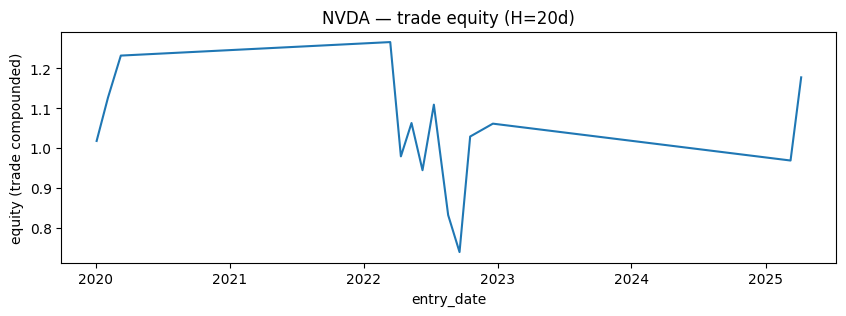

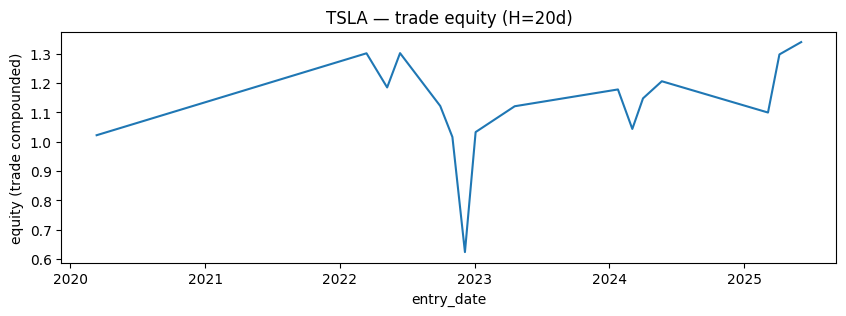

In [12]:
def plot_trade_equity(tr: pd.DataFrame, title: str):
    if tr.empty:
        print(f"No trades for {title}")
        return
    tr = tr.sort_values("entry_date").copy()
    tr["equity"] = (1 + tr["ret"]).cumprod()
    plt.figure(figsize=(10, 3))
    plt.plot(tr["entry_date"], tr["equity"])
    plt.title(title)
    plt.xlabel("entry_date")
    plt.ylabel("equity (trade compounded)")
    plt.show()

for t in sorted(trades["ticker"].unique()):
    plot_trade_equity(trades[trades["ticker"] == t], f"{t} — trade equity (H={HOLD_DAYS}d)")


In [13]:
def run_strategy_variant(frame: pd.DataFrame, name: str, entry_mask: pd.Series) -> pd.DataFrame:
    temp = frame.copy()
    temp["entry_signal"] = entry_mask
    tr = simulate_trades_no_overlap(temp, HOLD_DAYS)
    tr["strategy"] = name
    return tr

mask_combo = compute_entry_signal(df)
mask_regime_only = (df["regime_bucket_10"] <= REGIME_MAX)
mask_z_only = (df["zscore_bucket_10"] <= ZSCORE_MAX_BUCKET)

tr_combo = run_strategy_variant(df, "combo", mask_combo)
tr_reg = run_strategy_variant(df, "regime_only", mask_regime_only)
tr_z = run_strategy_variant(df, "z_only", mask_z_only)

all_tr = pd.concat([tr_combo, tr_reg, tr_z], ignore_index=True)

summ = (all_tr.groupby("strategy", as_index=False)
              .apply(lambda x: perf_summary(x, label=x["strategy"].iloc[0]))
              .reset_index(drop=True))

summ.sort_values("avg_ret", ascending=False)


/tmp/ipykernel_2622652/2628748322.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: perf_summary(x, label=x["strategy"].iloc[0]))


,label,n,avg_ret,med_ret,win_rate,p05,p25,p75,p95
2,z_only,316,0.027416,0.027070,0.601266,-0.156449,-0.040924,0.088782,0.195406
1,regime_only,124,0.024526,0.017164,0.556452,-0.223881,-0.083226,0.118793,0.281264
0,combo,108,0.017198,0.017164,0.546296,-0.212036,-0.089534,0.098899,0.255516


In [14]:
split_date = df["trade_date"].quantile(0.5)
early_df = df[df["trade_date"] <= split_date].copy()
late_df  = df[df["trade_date"] >  split_date].copy()

tr_early = simulate_trades_no_overlap(early_df.assign(entry_signal=compute_entry_signal(early_df)), HOLD_DAYS)
tr_late  = simulate_trades_no_overlap(late_df.assign(entry_signal=compute_entry_signal(late_df)), HOLD_DAYS)

perf_summary(tr_early, "early"), perf_summary(tr_late, "late")


(   label   n   avg_ret   med_ret  win_rate       p05       p25       p75  \
 0  early  68 -0.006265 -0.000485       0.5 -0.240227 -0.096491  0.078949   
 
         p95  
 0  0.167164  ,
   label   n   avg_ret   med_ret  win_rate       p05      p25       p75  \
 0  late  41  0.054274  0.044192  0.609756 -0.117898 -0.05813  0.133129   
 
         p95  
 0  0.312403  )